# Presence only data modelling - Generate Random Points
This notebook generates the background data points required for presence only models. For more on background points, read [this](https://rspatial.org/raster/sdm/3_sdm_absence-background.html).

In [ ]:
install.packages(c("dismo","maptools","glmnet","maxnet","raster","sp","pryr"))

In [1]:
library(maxnet)
library(glmnet)
library(dismo)

In [670]:
train <- read.csv("../data/train_val_random.csv", header=TRUE)
test  <- read.csv("../data/test_random.csv", header=TRUE)

# Presense only train data
train_only_presence <- train[train$presence == "1", ]

In [671]:
training_data_dates <- train_only_presence["observation_date"]

## Pseudo absences
Plotting Pseudo absences.

[1] 11030

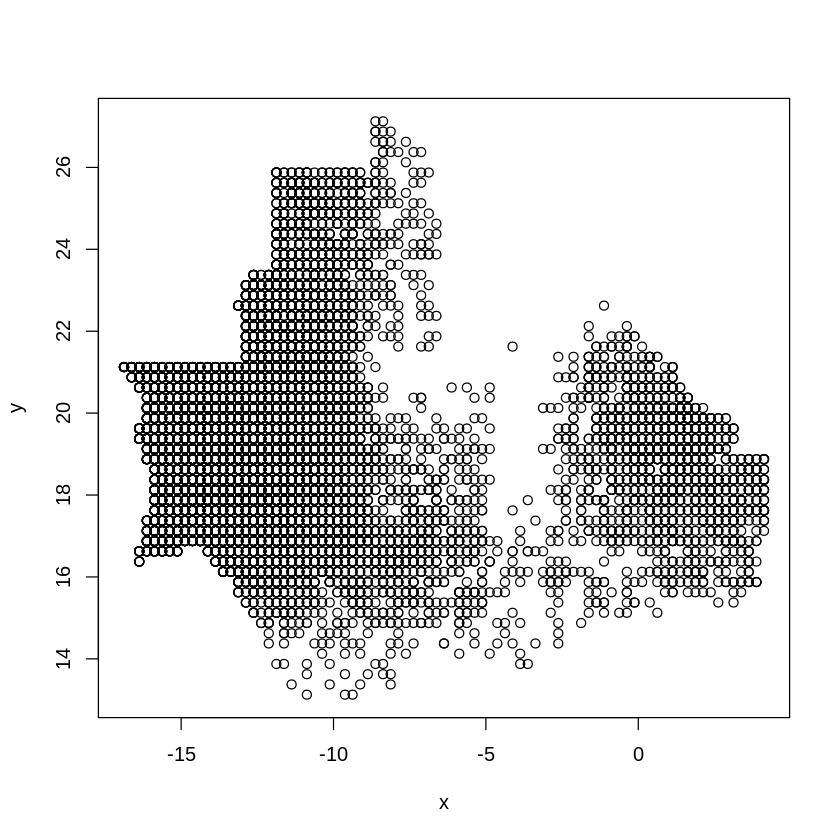

In [655]:
nrow(train[train$presence == "0", ][c("x","y")])
plot(train[train$presence == "0", ][c("x","y")])

# Generate Background Points
Randomly generate bakcground points.

## Randomly Generate x and y within country boundaries

[1] 11059

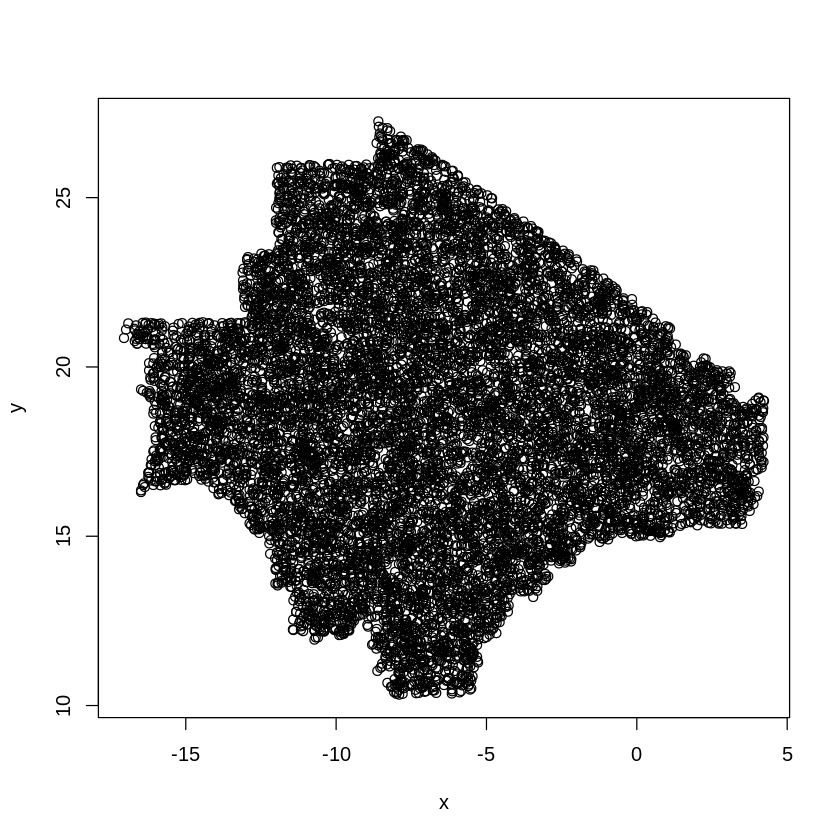

In [645]:
library(dismo)
set.seed(42)

# Get bounding box for mali and Mauritania
r <-  getData('alt' , country="Mauritania", level=0, mask=TRUE)
r1 <- getData('alt' , country="MALI", level=0, mask=TRUE)

combined_raster <- mosaic(r, r1, fun = min)

background_points <- randomPoints(combined_raster, nrow(train_only_presence))
nrow(background_points)
plot(background_points)

## Generate random dates within date range of training data 

In [647]:
min_date = min(as.Date(training_data_dates$observation_date,format="%Y-%m-%d"))
max_date = max(as.Date(training_data_dates$observation_date,format="%Y-%m-%d"))

background = as.data.frame(background_points)
background$date = sample(seq(min_date, max_date, by="day"), nrow(bg), replace=TRUE)

In [648]:
background

x,y,date
-7.270833333,13.24583,2003-10-21
-9.645833333,24.34583,2003-04-23
2.395833333,17.17083,2002-03-25
-9.287500000,20.35417,2009-02-13
-3.737500000,17.27083,2011-12-17
-12.212500000,16.89583,2008-01-18
-9.304166667,21.24583,2004-12-17
-7.262500000,23.20417,2000-09-08
-10.229166667,15.08750,2007-10-03
-7.604166667,19.13750,2013-12-01


In [657]:
write.csv(x=background, file="background.csv")